# Homework 1

In [1]:
import pandas as pd;
import networkx as nx;
import matplotlib.pyplot as plt;

## Data

In [2]:
jumbo_world_data_source = "../data/JumboWorld.txt"

jumbo_world_df = pd.read_csv(jumbo_world_data_source, delimiter="\t")

# Create a csv file with the adjacency matrix of the graph provided
def create_adjacency_file_undirected(graph: nx.Graph, filename: str):
    adjacency_matrix = nx.adjacency_matrix(graph).todense()
    node_labels =  nx.nodes(graph)
    adj_df  = pd.DataFrame(adjacency_matrix, columns=node_labels, index=node_labels)
    adj_df.to_csv(filename)


## Question 1: Families and parks

Construct the graph matching families and parks. Which park is the most popular? Which park is the least popular?

### Creating Graph

In [3]:
G = nx.Graph()

for index, row in jumbo_world_df.iterrows():
    G.add_edge(row['Family'], row['Park'])


### Most Visited Park

In [4]:
parks = jumbo_world_df["Park"].unique()

most_visited_park = max((park for park in parks), key=lambda park: G.degree(park))
print(f"Most Visited Park: {most_visited_park} with {G.degree(most_visited_park)} Families visiting")

Most Visited Park: Jumbo Kingdom with 676 Families visiting


### Least Visited Park

In [5]:

least_visited_park = min((park for park in parks), key=lambda park: G.degree(park))
print(f"Least Visited Park: {least_visited_park} with {G.degree(least_visited_park)} Families visiting")

Least Visited Park: Jumbo Golf Course with 185 Families visiting


### Visualization & Adjacency 

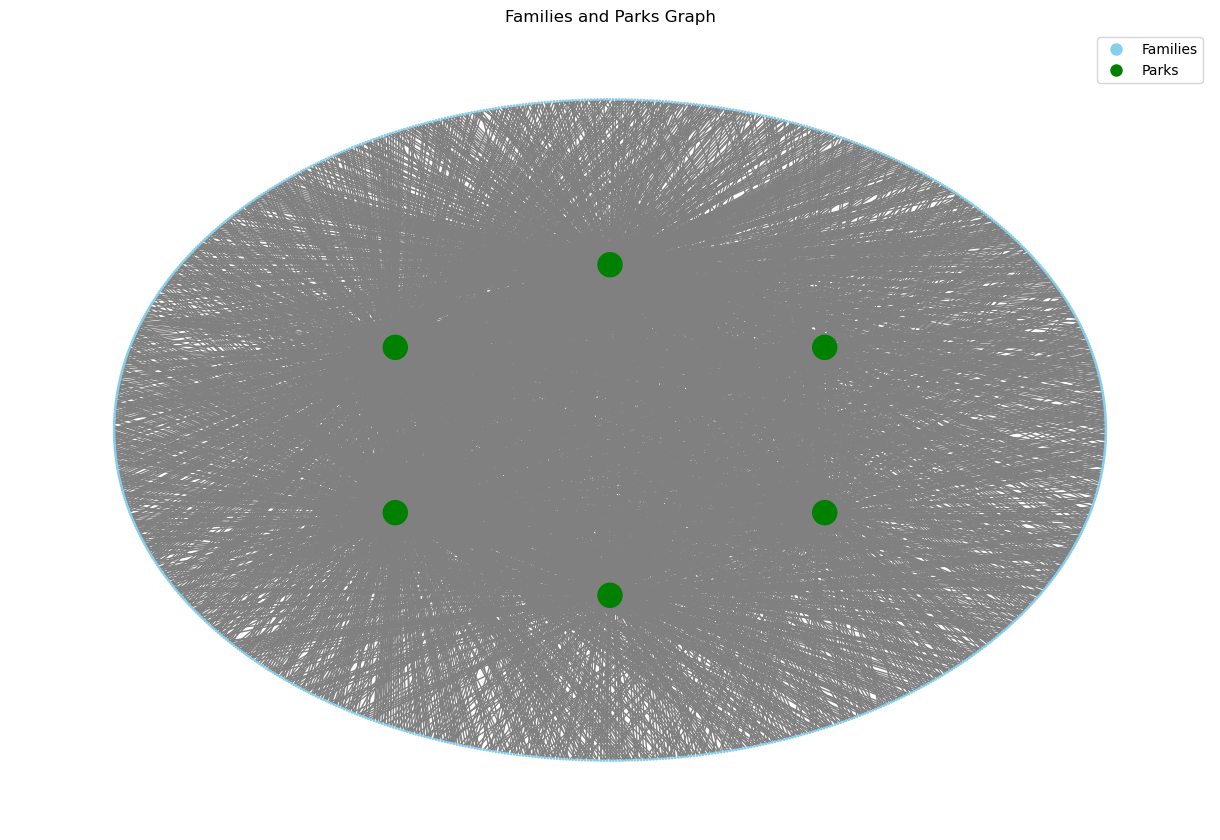

In [6]:
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 8))

# Get the list of parks
parks = jumbo_world_df["Park"].unique()

shell_layout = nx.shell_layout(G, nlist=[parks, [node for node in G.nodes() if node not in parks]])

# Create a color map for nodes and adjust sizes
node_colors = ["skyblue" if node not in parks else "green" for node in G.nodes()]
node_sizes = [1 if node not in parks else 300 for node in G.nodes()]

nx.draw(G, shell_layout, with_labels=False, node_size=node_sizes, node_color=node_colors, font_size=3, font_color="black", font_weight="bold", edge_color="gray")
plt.title("Families and Parks Graph")

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Families', markersize=10, markerfacecolor='skyblue'),
                   Line2D([0], [0], marker='o', color='w', label='Parks', markersize=10, markerfacecolor='green')]

plt.legend(handles=legend_elements)
plt.show()

In [7]:
# Create a adjacency matrix file
create_adjacency_file_undirected(G, "p1.csv")

## Question 2: Hotels and Parks

Construct the graph matching hotels and parks, with edges weighted
by the number of unique families that visit a park while staying at
a given hotel. Include a visualization of this graph using the graph
visualization program of your choice.



### Create Graph

Notes: We want to create edges from hotels to parks with weights that are the number of unique families that visit.
Get unique hotel and park pairs with the number of unique families

In [8]:
hotel_park_df = jumbo_world_df.groupby(["Hotel", "Park"])["Family"].nunique().reset_index(name='Unique_Family_Count').sort_index()

HotelParkGraph = nx.Graph()

header_row = hotel_park_df.columns.tolist()

for index, row in hotel_park_df.iterrows():
    HotelParkGraph.add_edge(row['Hotel'], row['Park'], weight=row["Unique_Family_Count"])


### Visualization

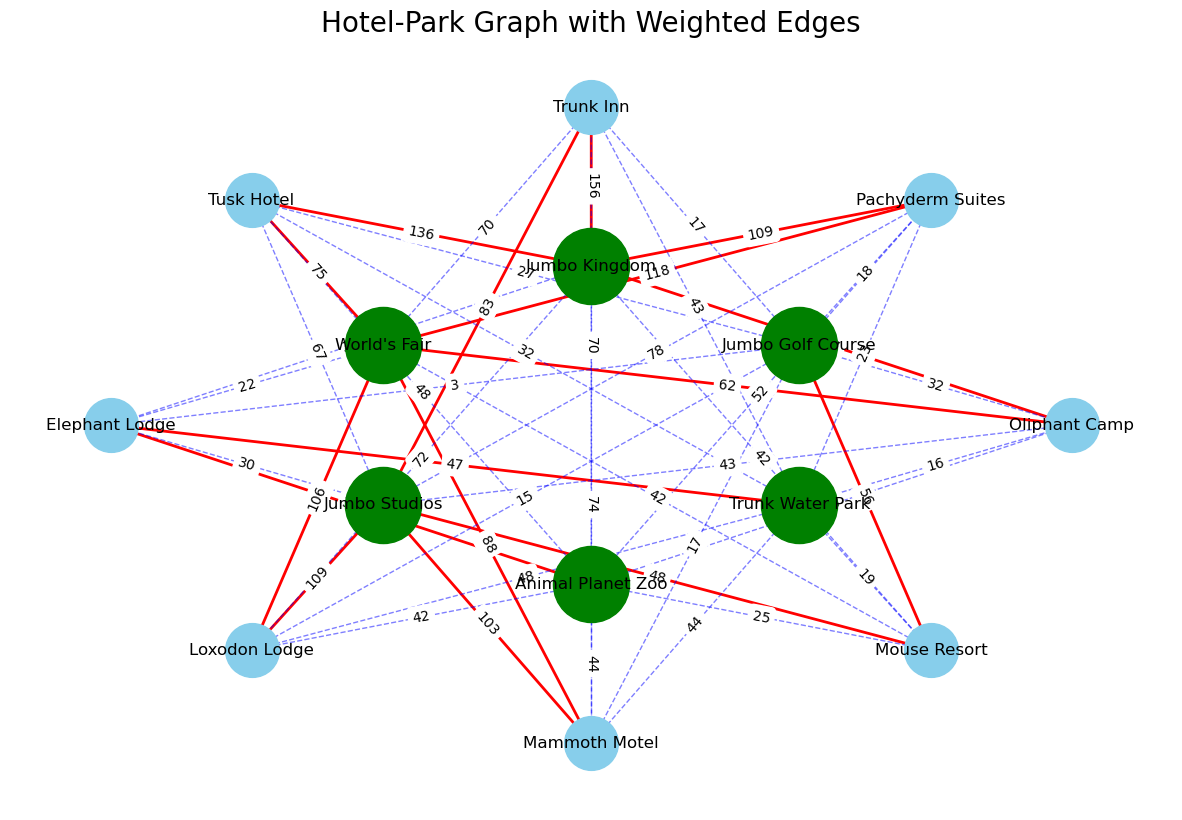

In [9]:
# Get the two largest edges from each hotel to park
top_edges = []
for hotel in hotel_park_df['Hotel'].unique():
    hotel_edges = hotel_park_df[hotel_park_df['Hotel'] == hotel].nlargest(2, 'Unique_Family_Count')
    top_edges.extend([(row['Hotel'], row['Park']) for _, row in hotel_edges.iterrows()])

# Separate edges into large and small
elarge = [(u, v) for (u, v, d) in HotelParkGraph.edges(data=True) if (u, v) in top_edges or (v, u) in top_edges]
esmall = [(u, v) for (u, v, d) in HotelParkGraph.edges(data=True) if (u, v) not in top_edges and (v, u) not in top_edges]

# Create a shell layout with parks in the inner shell and hotels in the outer shell
shell_layout = nx.shell_layout(HotelParkGraph, nlist=[parks, [node for node in HotelParkGraph.nodes if node not in parks]])

plt.figure(figsize=(15, 10))

# nodes
nx.draw_networkx_nodes(HotelParkGraph, shell_layout, nodelist=parks, node_color="green", node_size=3000)
nx.draw_networkx_nodes(HotelParkGraph, shell_layout, nodelist=[node for node in HotelParkGraph.nodes if node not in parks], node_color="skyblue", node_size=1500)

# edges
nx.draw_networkx_edges(HotelParkGraph, shell_layout, edgelist=elarge, width=2, edge_color="red")
nx.draw_networkx_edges(
    HotelParkGraph, shell_layout, edgelist=esmall, width=1, alpha=0.5, edge_color="blue", style="dashed"
)

# node labels
nx.draw_networkx_labels(HotelParkGraph, shell_layout, font_size=12, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(HotelParkGraph, "weight")
nx.draw_networkx_edge_labels(HotelParkGraph, shell_layout, edge_labels, font_size=10)

plt.title("Hotel-Park Graph with Weighted Edges", fontsize=20)
plt.axis("off")
plt.show()

In [10]:
# export to csv file

create_adjacency_file_undirected(HotelParkGraph, "p2.csv")

## Question 3: Families with 2 Parks in Common


Construct a graph of families, with edges between families if they visit
at least two of the same parks.

In [11]:
families_graph = nx.Graph()
edges = []

# Create a dictionary to store the parks visited by each family
family_parks = jumbo_world_df.groupby('Family')['Park'].apply(set).to_dict()

print(family_parks)

# Iterate over all pairs of families
for family1 in family_parks:
    for family2 in family_parks:
        if family1 != family2:
            # Find the common parks visited by both families
            common_parks = family_parks[family1].intersection(family_parks[family2])
            # If they have at least two parks in common, add an edge between them
            if len(common_parks) >= 2:
                edges.append((family1, family2))

families_graph.add_edges_from(edges)


{'Abbott': {'Jumbo Studios'}, 'Acevedo': {'Animal Planet Zoo', 'Jumbo Studios', 'Jumbo Kingdom'}, 'Acosta': {'Animal Planet Zoo', 'Jumbo Studios'}, 'Adams': {'Jumbo Studios', 'Jumbo Kingdom', "World's Fair"}, 'Adkins': {'Trunk Water Park', 'Jumbo Studios', "World's Fair"}, 'Aguilar': {'Jumbo Studios', 'Jumbo Kingdom', "World's Fair"}, 'Aguirre': {'Animal Planet Zoo', 'Jumbo Kingdom', 'Trunk Water Park'}, 'Albert': {'Jumbo Kingdom', "World's Fair"}, 'Alexander': {'Trunk Water Park', 'Jumbo Studios', "World's Fair"}, 'Alford': {'Animal Planet Zoo', 'Jumbo Kingdom', "World's Fair"}, 'Allen': {'Trunk Water Park', 'Jumbo Studios', 'Jumbo Kingdom'}, 'Allison': {'Trunk Water Park', 'Jumbo Studios'}, 'Alston': {'Trunk Water Park', 'Jumbo Kingdom', "World's Fair"}, 'Alvarado': {'Animal Planet Zoo', 'Jumbo Kingdom'}, 'Alvarez': {'Trunk Water Park', 'Jumbo Studios', 'Jumbo Kingdom'}, 'Anderson': {'Jumbo Studios', 'Jumbo Kingdom'}, 'Andrews': {'Trunk Water Park', 'Jumbo Studios', 'Jumbo Kingdom'},

### Visualize

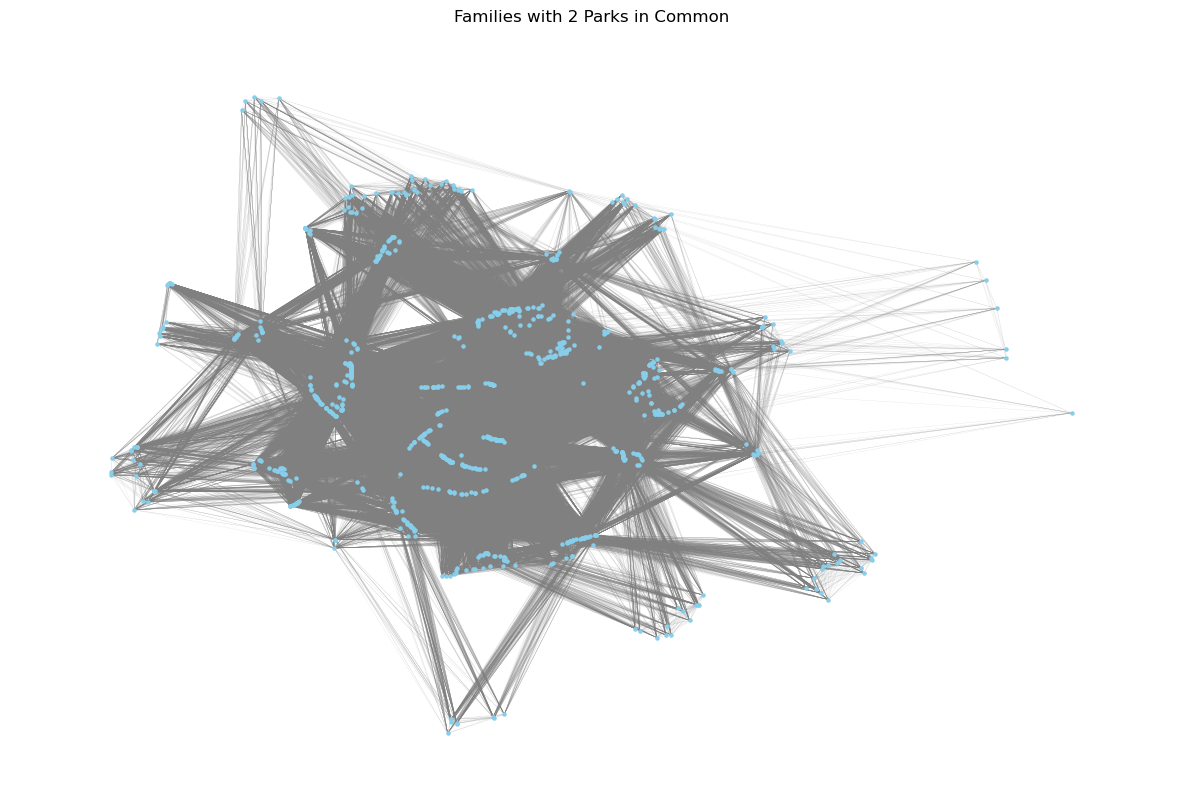

In [12]:

plt.figure(figsize=(15, 10))

pos = nx.spring_layout(families_graph, seed=42)

nx.draw_networkx_nodes(families_graph, pos, node_size=5, node_color="skyblue")

nx.draw_networkx_edges(families_graph, pos, width=0.1, alpha=0.5, edge_color="gray")


plt.title("Families with 2 Parks in Common")
plt.axis("off")
plt.show()

### Export to CSV

In [13]:
# export to csv
create_adjacency_file_undirected(families_graph, "p3.csv")

## Question 4: Families with 2 Parks in Common on Same Day

### Create Graph

In [14]:
family_parks_and_day = jumbo_world_df.groupby('Family')["Park"].apply(set).to_dict()
family_parks_and_day = jumbo_world_df.groupby('Family').apply(lambda x: list(zip(x['Park'], x['Day']))).to_dict()

In [15]:
families_graph2 = nx.Graph()
edges_fams2 = []

# Iterate over all pairs of families
for family1 in family_parks:
    for family2 in family_parks:
        if family1 != family2:
            # Find the common parks visited by both families
            common_parks_and_days = set(family_parks_and_day[family1]).intersection(set(family_parks_and_day[family2]))
            # If they have at least two parks in common on the same day, add an edge between them
            if len(common_parks_and_days) >= 2:
                edges_fams2.append((family1, family2))

families_graph2.add_edges_from(edges_fams2)

# Comments

### Visualize

In [16]:
plt.figure(figsize=(15, 10))

pos = nx.spring_layout(families_graph2, seed=42)

nx.draw_networkx_nodes(families_graph2, pos, node_size=5, node_color="skyblue")

nx.draw_networkx_edges(families_graph2, pos, width=0.1, alpha=0.5, edge_color="gray")


plt.title("Families with 2 Parks in Common on the Same Day")
plt.axis("off")
plt.show()

KeyboardInterrupt: 

<Figure size 1500x1000 with 0 Axes>

In [42]:
# export to csv
create_adjacency_file_undirected(families_graph2, "p4.csv")

### How does the graph change?

The graph, when only adding edges when the two families visit the same parks on the same day, becomes far less dense than the previous graph in question 3. This makes sense; it is less likely that two families visited the same parks on the same days rather than just the same parks in general. 

## Question 5

From the graphs, we can infer that families choose to stay at hotels which are close to the parks which they want to visit, or conversely, they visit parks close to their hotels. If we take this assumption along with the graph that we created for Question 2, we can build a rough idea of the layout of the park based on the number of hotel to park connections.

Jumbo Studios, Jumbo Kingdom, and World's Fair all have 4 or 5 strong connections to hotels, so it is likely that they are in a central location in the park. Trunk Water Park and Animal Planet Zoo are probably on the perimeter close to Elephant Lodge. Jumbo Golf Course is probably on the other side of the park on the perimeter and close to Mouse Resort.

We can infer a lot about the geography of the park based on the connections of the hotels to the parks.